<a href="https://colab.research.google.com/github/ewmew11/ALLINSHOP/blob/master/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

In [ ]:
import numpy as np
from scipy.signal import convolve,convolve2d
from H_Metrix import H_Metrix
from m_find_EQ_Karakulak_Full_TaR import m_find_EQ_Karakulak_Full_TaR
from c_vit_dec import c_vit_dec
from c_Viterbi2D_64s8b import c_Viterbi2D_64s8b
import multiprocessing as mp
import matplotlib.pyplot as plt

import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from keras import regularizers
from keras.layers import Dense, Input, BatchNormalization, Dropout
import keras
from sklearn.utils import shuffle

ModuleNotFoundError: No module named 'drive'

In [ ]:
import pandas as pd
Yk_all_df = pd.read_csv(drive.MyDrive.py_sci.Yk_all_100.csv)
Yk_all_df = Yk_all_df.drop(columns=['Unnamed: 0'])
Yk_sector_SNRdB = Yk_all_df[['sector', 'SNRdB']]
Yk_all_df = Yk_all_df.drop(columns=['sector', 'SNRdB'])
Yk_all = Yk_all_df.values

print('Yk_all:', Yk_all.shape)

Yk_all_dict = {}

for SNRdB in Yk_sector_SNRdB['SNRdB'].unique():
    for sector in Yk_sector_SNRdB['sector'].unique():
        Yk_all_SNRdB_sector = Yk_all_df[(Yk_sector_SNRdB['SNRdB'] == SNRdB) & (Yk_sector_SNRdB['sector'] == sector)].values
        Yk_all_dict[(SNRdB, sector)] = Yk_all_SNRdB_sector

# for SNRdB, array in Yk_all_dict.items():
#     print(f"SNRdB: {SNRdB}, shape: {array.shape}")

Ak_all_df = pd.read_csv("Ak_all_100_1.csv")
Ak_all_df = Ak_all_df.drop(columns=['Unnamed: 0'])
Ak_sector_SNRdB = Ak_all_df[['sector', 'SNRdB']]
Ak_all_df = Ak_all_df.drop(columns=['sector', 'SNRdB'])
Ak_all = Ak_all_df.values

print('Ak_all:', Ak_all.shape)

Ak_all_dict = {}

for SNRdB in Ak_sector_SNRdB['SNRdB'].unique():
    for sector in Ak_sector_SNRdB['sector'].unique():
        Ak_all_SNRdB_sector = Ak_all_df[(Ak_sector_SNRdB['SNRdB'] == SNRdB) & (Ak_sector_SNRdB['sector'] == sector)].values
        Ak_all_dict[(SNRdB, sector)] = Ak_all_SNRdB_sector

# for SNRdB, array in Ak_all_dict.items():
#     print(f"SNRdB: {SNRdB}, shape: {array.shape}")

Yk_all = []
Ak_all = []

for SNRdB in range(12, 29):
    for sector in range(1, 101):

        Ak = Ak_all_dict[(SNRdB,sector)]
        Yk = Yk_all_dict[(SNRdB,sector)]
        Yk = Yk.reshape(1, -1)

        # number of bits
        num = 27
        n = Yk.shape[1] // num * num
        Yk = Yk[:,:n]
        Yk = Yk.reshape(-1, num)

        n = Ak.shape[1] // num * num
        Ak = Ak[:,:n]
        Ak = Ak.reshape(-1, num)

        Yk_all.append(Yk)
        Ak_all.append(Ak)

Yk_all = np.concatenate(Yk_all, axis=0)
Ak_all = np.concatenate(Ak_all, axis=0)

min_length = min(Yk_all.shape[0], Ak_all.shape[0])
Yk_all = Yk_all[:min_length, :]
Ak_all = Ak_all[:min_length, :]

print('Yk_all:', Yk_all.shape)
print('Ak_all:', Ak_all.shape)

NameError: name 'drive' is not defined

In [ ]:
scaler = StandardScaler()
Yk_all = scaler.fit_transform(Yk_all)
Ak_all = scaler.fit_transform(Ak_all)

Yk_all, Ak_all = shuffle(Yk_all, Ak_all, random_state=42)
Yk_train, Yk_test, Ak_train, Ak_test = train_test_split(Yk_all, Ak_all, test_size=0.1, random_state=42)

print(Yk_train.shape[1],)
input_shape = (Yk_train.shape[1],)

# Define the model
model = Sequential()
model.add(Input(shape=input_shape))  # Input layer

# Hidden layers
neurons = [128,128,128,128]

for n in neurons:
    model.add(Dense(n, activation=keras.activations.relu, kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.01))

# Output layer
model.add(Dense(Ak_train.shape[1], activation=keras.activations.linear, kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001)))

# Learning rate schedule
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9)

# Compile the model
model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=[keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError()])

# model.load_weights('best_model.keras')
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Train the model
history = model.fit(Yk_train, Ak_train,
                    epochs=1000,
                    batch_size=64,
                    validation_data=(Yk_test, Ak_test),
                    callbacks=[early_stopping],
                    verbose=1)

model.summary()


27
Epoch 1/1000
3658/3658 [==============================] - 20s 5ms/step - loss: 0.5421 - mean_squared_error: 0.3277 - mean_absolute_error: 0.4118 - val_loss: 0.1967 - val_mean_squared_error: 0.1410 - val_mean_absolute_error: 0.2060
Epoch 2/1000
3658/3658 [==============================] - 14s 4ms/step - loss: 0.2116 - mean_squared_error: 0.1699 - mean_absolute_error: 0.2196 - val_loss: 0.1423 - val_mean_squared_error: 0.1087 - val_mean_absolute_error: 0.1550
Epoch 3/1000
3658/3658 [==============================] - 14s 4ms/step - loss: 0.1716 - mean_squared_error: 0.1429 - mean_absolute_error: 0.1957 - val_loss: 0.1226 - val_mean_squared_error: 0.0977 - val_mean_absolute_error: 0.1350
Epoch 4/1000
3658/3658 [==============================] - 14s 4ms/step - loss: 0.1533 - mean_squared_error: 0.1309 - mean_absolute_error: 0.1874 - val_loss: 0.1147 - val_mean_squared_error: 0.0946 - val_mean_absolute_error: 0.1278
Epoch 5/1000
3658/3658 [==============================] - 15s 4ms/step - 

Test MAE: 0.08837725222110748
Test loss: 0.10102558881044388
Test MSE: 0.10689958930015564
813/813 [==============================] - 1s 1ms/step


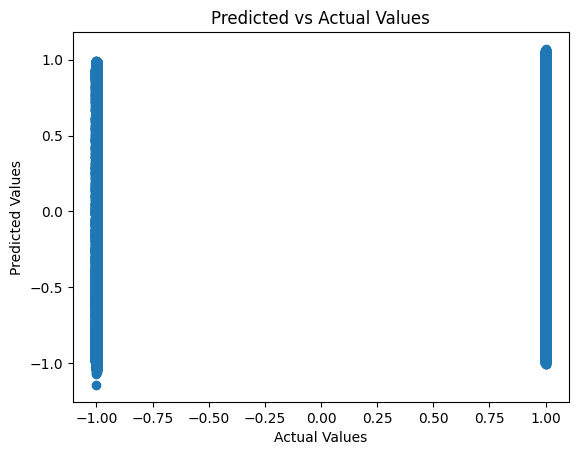

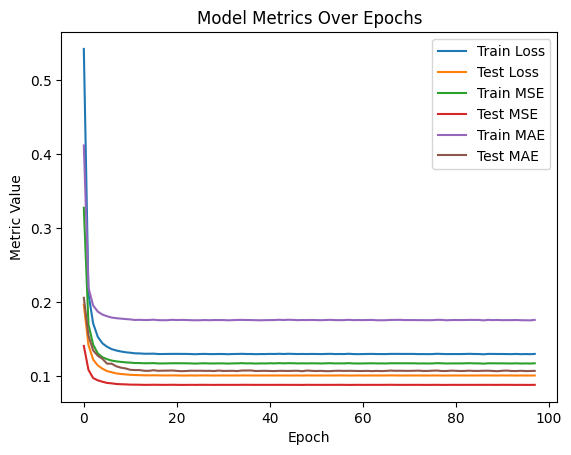

In [ ]:
# print(history.history.keys())
loss, mean_absolute_error,mean_squared_error= model.evaluate(Yk_test, Ak_test, verbose=0)

print(f"Test MAE: {mean_absolute_error}")
print(f"Test loss: {loss}")
print(f"Test MSE: {mean_squared_error}")

# Make predictions
Ak_pred = model.predict(Yk_test)

# Plot predicted vs actual values
plt.scatter(Ak_test, Ak_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

# Plot training & validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model Metrics Over Epochs')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Test Loss', 'Train MSE', 'Test MSE', 'Train MAE', 'Test MAE'], loc='upper right')
plt.show()

In [ ]:
Ak_all_df = pd.read_csv("Ak_all_100.csv")
Ak_all_df = Ak_all_df.drop(columns=['Unnamed: 0'])

Ak_sector_SNRdB = Ak_all_df[['sector', 'SNRdB']]
Ak_all_df = Ak_all_df.drop(columns=['sector', 'SNRdB'])

Ak_all_dict = {}

for SNRdB in Ak_sector_SNRdB['SNRdB'].unique():
    for sector in Ak_sector_SNRdB['sector'].unique():
        Ak_all_SNRdB_sector = Ak_all_df[(Ak_sector_SNRdB['SNRdB'] == SNRdB) & (Ak_sector_SNRdB['sector'] == sector)].values
        Ak_all_dict[(SNRdB, sector)] = Ak_all_SNRdB_sector

print('Ak_all_dict:', Ak_all_dict[(20, 1)].shape)

Ak_all_df_1 = pd.read_csv("Ak_all_100_1.csv")
Ak_all_df_1 = Ak_all_df_1.drop(columns=['Unnamed: 0'])
Ak_sector_SNRdB_1 = Ak_all_df_1[['sector', 'SNRdB']]
Ak_all_df_1 = Ak_all_df_1.drop(columns=['sector', 'SNRdB'])
Ak_all_1 = Ak_all_df_1.values

Ak_all_dict_1 = {}

for SNRdB in Ak_sector_SNRdB_1['SNRdB'].unique():
    for sector in Ak_sector_SNRdB_1['sector'].unique():
        Ak_all_df_1_SNRdB_sector = Ak_all_df_1[(Ak_sector_SNRdB_1['SNRdB'] == SNRdB) & (Ak_sector_SNRdB_1['sector'] == sector)].values
        Ak_all_dict_1[(SNRdB, sector)] = Ak_all_df_1_SNRdB_sector


Yk_all_df = pd.read_csv("Yk_all_100.csv")
Yk_all_df = Yk_all_df.drop(columns=['Unnamed: 0'])
Yk_sector_SNRdB = Yk_all_df[['sector', 'SNRdB']]
Yk_all_df = Yk_all_df.drop(columns=['sector', 'SNRdB'])
Yk_all = Yk_all_df.values


Yk_all_dict = {}

for SNRdB in Yk_sector_SNRdB['SNRdB'].unique():
    for sector in Yk_sector_SNRdB['sector'].unique():
        Yk_all_SNRdB_sector = Yk_all_df[(Yk_sector_SNRdB['SNRdB'] == SNRdB) & (Yk_sector_SNRdB['sector'] == sector)].values
        Yk_all_dict[(SNRdB, sector)] = Yk_all_SNRdB_sector

print('Yk_all_dict:', Yk_all_dict[(20, 1)].shape)


Ak_all_dict: (3, 4146)
Yk_all_dict: (1, 4148)


In [ ]:
AD = 3
SNRdB = 20
LL = 4096
Depth = 50
L_Total = LL + Depth
H = H_Metrix(AD)

Ak = Ak_all_dict[(SNRdB, 1)]
Yk = Yk_all_dict[(SNRdB, 1)]
L = 3

estG, estF, error = m_find_EQ_Karakulak_Full_TaR(Yk[:LL], Ak[:, :LL], L)
estF = estF.reshape(-1 , 1)

SNRdBALL = np.arange(12, 29, 1)

BER1 = np.zeros_like(SNRdBALL, dtype=float)
BER2 = np.zeros_like(SNRdBALL, dtype=float)

for ii, SNRdB in enumerate(SNRdBALL):
    Err1 = 0
    Err2 = 0

    for jj in range(1, 101.        ):
        Ak = Ak_all_dict_1[(SNRdB, jj)]
        Ak_3 = Ak_all_dict[(SNRdB, jj)]
        Yk = Yk_all_dict[(SNRdB, jj)]

        Yk = Yk.reshape(1, -1)
        Yk = Yk.flatten()

        Rk1 = convolve(estF.flatten(), Yk, mode='full')  #equalizer
        Rk1 = Rk1[L:] #output of an equalizer

        # number of bits
        num = 27

        n = Yk.shape[0] // num * num
        Yk = Yk[:n]
        Ak = Ak[:,:n]

        # Reshape Yk to match the input shape of the model
        Yk = Yk.reshape(-1, num)

        # Use the model to make a prediction for all chunks of Yk
        Ak_pred = model.predict(Yk, verbose=0)

        # Apply threshold to the predictions
        Ak_pred = np.where(Ak_pred >= 0, 1, -1)

        # Reshape Ak_pred to match the shape of Ak
        Ak_pred = Ak_pred.reshape(Ak.shape)

        Err1 += np.sum(Ak[:LL] != Ak_pred[:LL])

        # [Upper, Decode1, Lower] = c_Viterbi2D_64s8b(Rk1, estG, Depth)
        # Err2 += np.sum(Ak_3[1, :LL] != Decode1[:LL])

    BER1[ii] = Err1 / (jj * LL)
    # BER2[ii] = Err2 / (jj * LL)
    print('BER1 = ', BER1[ii], 'ii = ', ii)
    # print('BER2 = ', BER2[ii], 'ii = ', ii)

BER1 =  0.070703125 ii =  0
BER1 =  0.06385498046875 ii =  1
BER1 =  0.0568603515625 ii =  2
BER1 =  0.050048828125 ii =  3
BER1 =  0.0439453125 ii =  4
BER1 =  0.0369873046875 ii =  5
BER1 =  0.03160400390625 ii =  6
BER1 =  0.0273681640625 ii =  7
BER1 =  0.02369384765625 ii =  8
BER1 =  0.02039794921875 ii =  9
BER1 =  0.0181640625 ii =  10
BER1 =  0.01700439453125 ii =  11
BER1 =  0.01627197265625 ii =  12
BER1 =  0.0153076171875 ii =  13
BER1 =  0.01597900390625 ii =  14
BER1 =  0.01534423828125 ii =  15
BER1 =  0.0161376953125 ii =  16


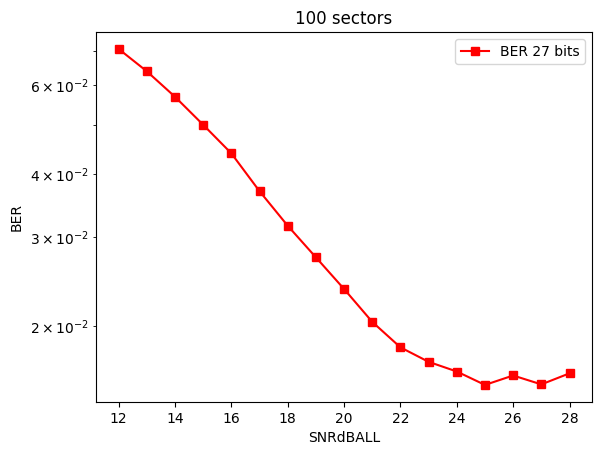

In [ ]:
# plot
SNRdBALL = np.arange(12, 29, 1)
#print('BER1:', BER1)
BER4 =  np.zeros_like(SNRdBALL, dtype=float)
BER3 =  np.zeros_like(SNRdBALL, dtype=float)
BER2 =  np.zeros_like(SNRdBALL, dtype=float)

plt.figure()
plt.semilogy(SNRdBALL, BER1, '-sr', label='BER 27 bits')
# plt.semilogy(SNRdBALL, BER2, '-ob', label='BER 7 bits')
# plt.semilogy(SNRdBALL, BER3, '-xg', label='BER 5 bits')
# plt.semilogy(SNRdBALL, BER4, '-*k', label='BER 3 bits')
plt.xlabel('SNRdBALL')
plt.ylabel('BER')
plt.title('100 sectors')
plt.legend()
plt.show()